<a href="https://colab.research.google.com/github/Vedant-cloud-ctrl/LLoyd-Banking-Group/blob/main/Lloyd_Banking_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import libraries
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Upload file
from google.colab import files
upload = files.upload()

Saving Customer_Churn_Data_Large(2).xlsx to Customer_Churn_Data_Large(2) (1).xlsx


In [8]:
sheets = pd.read_excel(io.BytesIO(upload["Customer_Churn_Data_Large(2) (1).xlsx"]), sheet_name=None, index_col=0)
sheets.keys()

dict_keys(['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status'])

# Understanding Data & each col values

In [9]:
# Accessing each sheets
sheet_1 = sheets["Customer_Demographics"]
sheet_2 = sheets["Transaction_History"]
sheet_3 = sheets["Customer_Service"]
sheet_4 = sheets["Online_Activity"]
sheet_5 = sheets["Churn_Status"]

# 1. Inspect Customer Demographics
print("\nCustomer Demographics")
sheet_1.info()

# 2. Inspect Transaction History
print("\nTransactions History")
sheet_2.info()

# 3. Inspect Customer Service
print("\nCustomer Service")
sheet_3.info()

# 4. Inspect Online Activity
print("\n Online Activity")
sheet_4.info()

# 5. Inspect Churn Status
print("\nChurn Status")
sheet_5.info()


Customer Demographics
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            1000 non-null   int64 
 1   Gender         1000 non-null   object
 2   MaritalStatus  1000 non-null   object
 3   IncomeLevel    1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.1+ KB

Transactions History
<class 'pandas.core.frame.DataFrame'>
Index: 5054 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    5054 non-null   int64         
 1   TransactionDate  5054 non-null   datetime64[ns]
 2   AmountSpent      5054 non-null   float64       
 3   ProductCategory  5054 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 197.4+ KB

Customer Service
<class 'pandas.core.frame

Note: We see the big diff in two sheets i.e., Transaction History & Customer Service where the values are high as compared to other cols. The main reason would be that each customer has done multiple transaction and also where a single customer has participate in performing repeptitive activities.  

# Handling missing values & merge the sheets

In [10]:
# Step1: Convert date cols into datetime
sheet_2["TransactionDate"] = pd.to_datetime(sheet_2["TransactionDate"])
sheet_3["InteractionDate"] = pd.to_datetime(sheet_3["InteractionDate"])
sheet_4["LastLoginDate"] = pd.to_datetime(sheet_4["LastLoginDate"])


# Step2: Aggregate transaction to 1 per row customer (keep latest transaction)
# we first sort the dates value and then groupby it with cutomerid
sheet_2_unique = sheet_2.sort_values("TransactionDate").groupby("CustomerID").last().reset_index()

# Step3: Aggregate interactiondates to 1 per row customer (keep latest interaction)
sheet_3_unique = sheet_3.sort_values("InteractionDate").groupby("CustomerID").last().reset_index()

# merge
df = sheet_1.merge(sheet_2_unique, on="CustomerID", how="left")
df = df.merge(sheet_3_unique, on="CustomerID", how="left")
df = df.merge(sheet_4, on="CustomerID", how="left")
df = df.merge(sheet_5, on="CustomerID", how="left")

# info
# df.info() # --> InteractionDate, InteractionID, InteractionType and ResolutionStatus shows 668

# handle missing
# since not all the customers had service interaction, those cols will be NANs
service_cols = ["InteractionID", "InteractionDate", "InteractionType", "ResolutionStatus"]
for col in service_cols:
  if df[col].dtype == "object" or df[col].dtype == "datetime64[ns]":
    df[col] = df[col].fillna("NaT")
  else:
    df[col] = df[col].fillna(0)

# drop the unique identifier
df.drop(columns=["TransactionID", "InteractionID"], inplace=True)

# print information
print(df.info())
df.to_csv("Customer_Churn_Data.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        1000 non-null   int64         
 1   Age               1000 non-null   int64         
 2   Gender            1000 non-null   object        
 3   MaritalStatus     1000 non-null   object        
 4   IncomeLevel       1000 non-null   object        
 5   TransactionDate   1000 non-null   datetime64[ns]
 6   AmountSpent       1000 non-null   float64       
 7   ProductCategory   1000 non-null   object        
 8   InteractionDate   668 non-null    datetime64[ns]
 9   InteractionType   1000 non-null   object        
 10  ResolutionStatus  1000 non-null   object        
 11  LastLoginDate     1000 non-null   datetime64[ns]
 12  LoginFrequency    1000 non-null   int64         
 13  ServiceUsage      1000 non-null   object        
 14  ChurnStatus       1000 no

# EDA

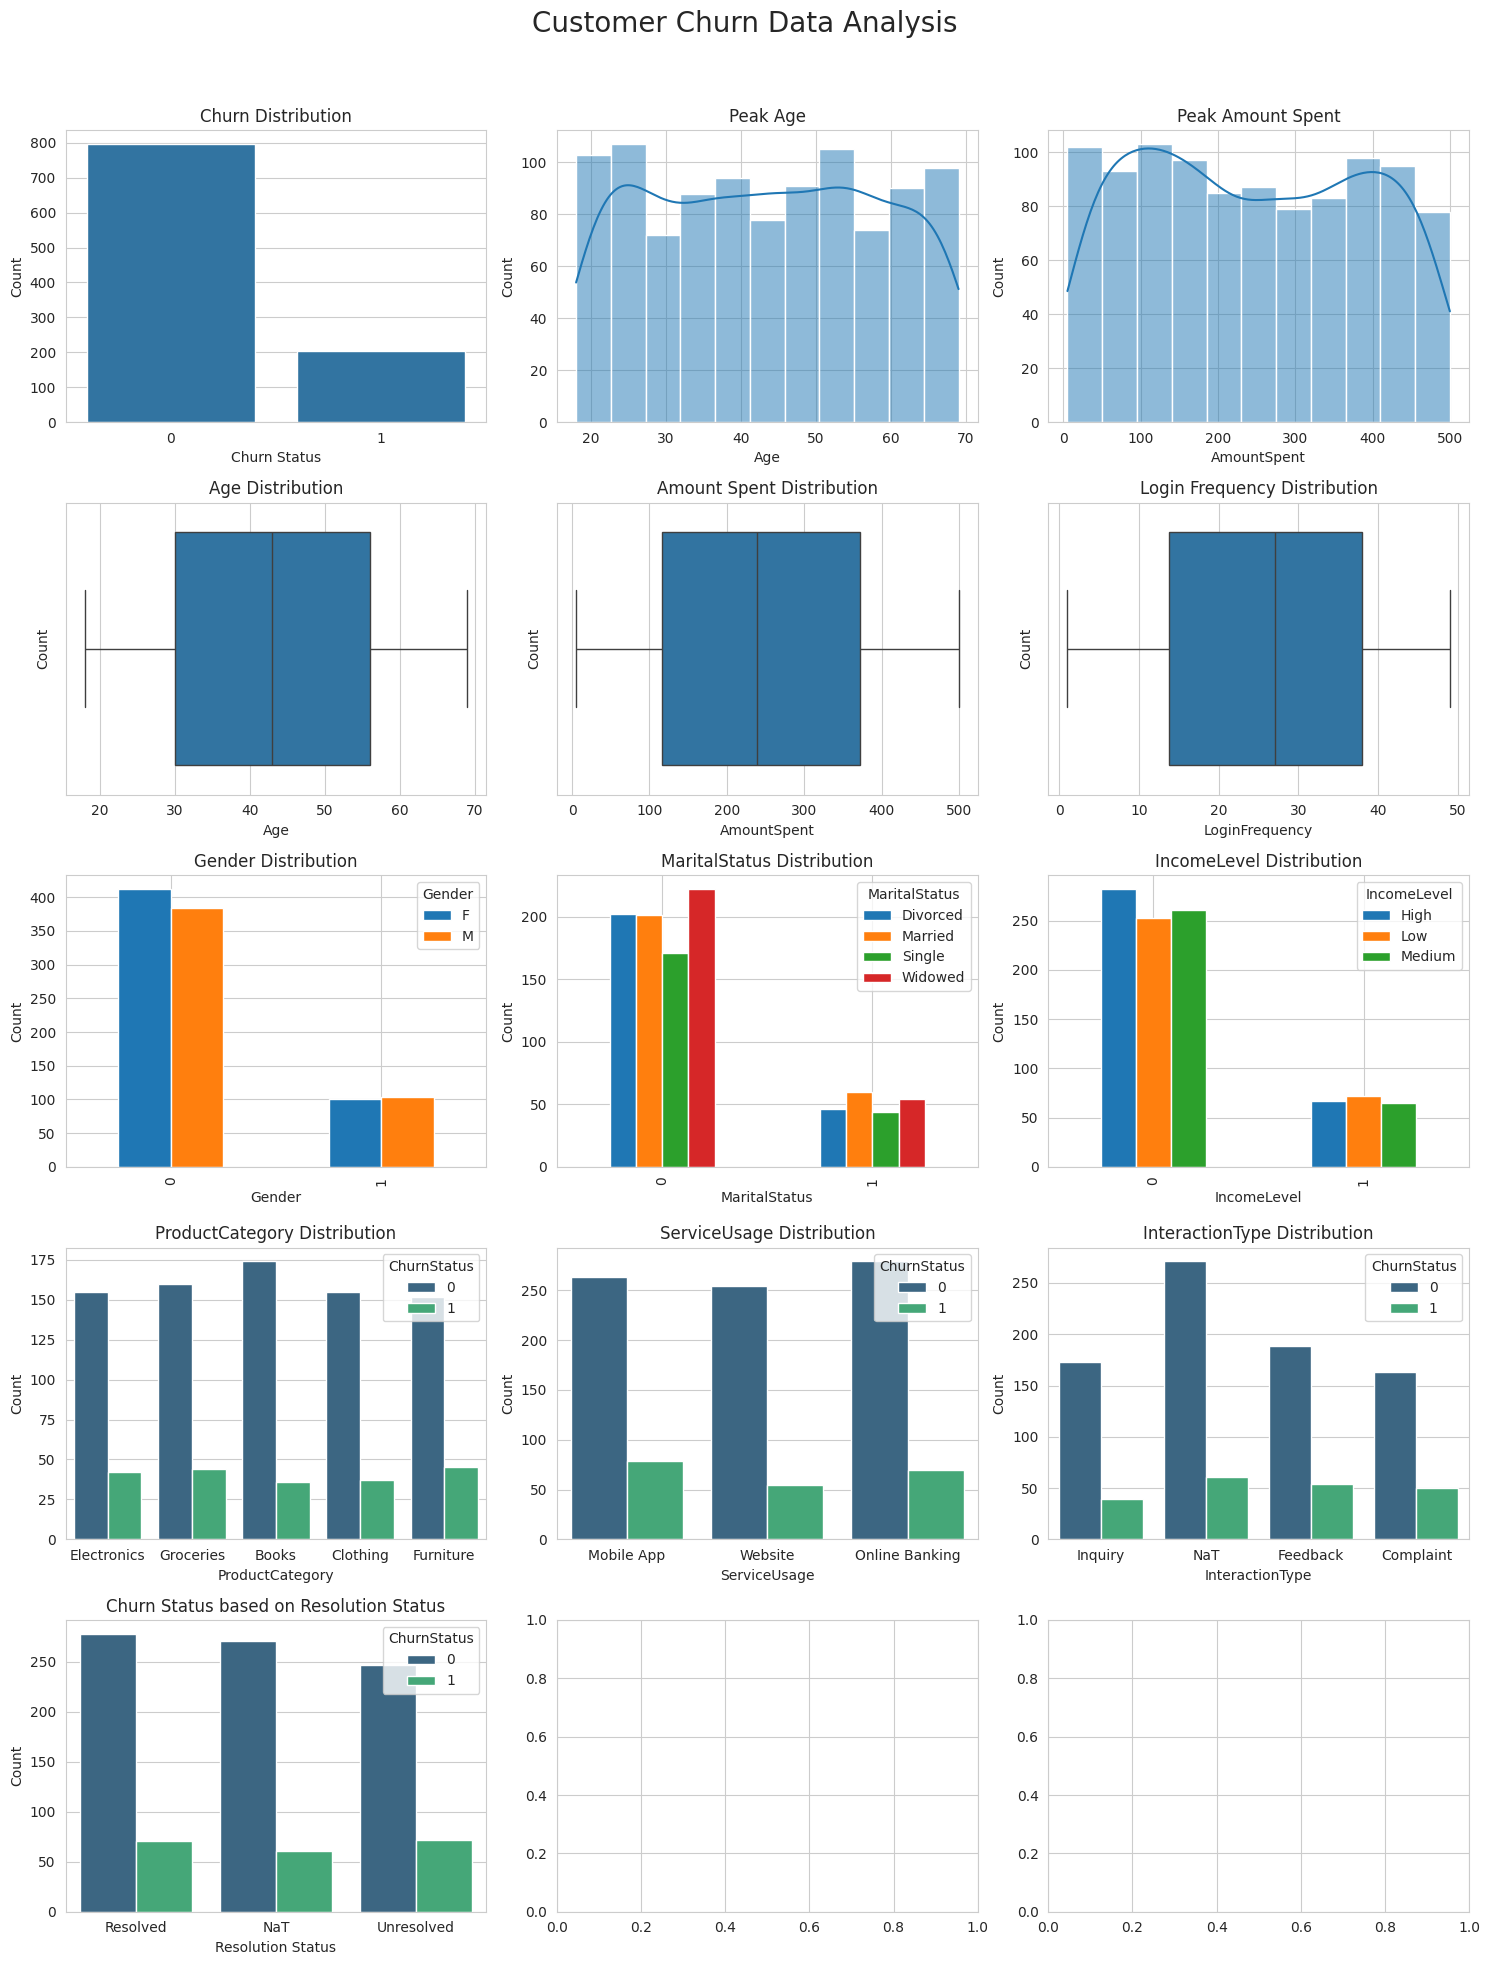

In [11]:
# set whitegrid
sns.set_style("whitegrid")

# create a fig with subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
fig.suptitle("Customer Churn Data Analysis", fontsize=20)

# Customer Churn Distribution
sns.countplot(x="ChurnStatus", data=df, ax=axes[0, 0])
axes[0, 0].set_xlabel("Churn Status")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Churn Distribution")

# peak age using histogram
sns.histplot(x="Age", data=df, kde=True, ax=axes[0, 1])
axes[0, 1].set_xlabel("Age")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_title("Peak Age")

# peak amountspent
sns.histplot(x="AmountSpent", data=df, kde=True, ax=axes[0, 2])
axes[0, 2].set_xlabel("AmountSpent")
axes[0, 2].set_ylabel("Count")
axes[0, 2].set_title("Peak Amount Spent")

# Age Distribution
sns.boxplot(x="Age", data=df, ax=axes[1, 0])
axes[1, 0].set_xlabel("Age")
axes[1, 0].set_ylabel("Count")
axes[1, 0].set_title("Age Distribution")

# Amountspent Distribution
sns.boxplot(x="AmountSpent", data=df, ax=axes[1, 1])
axes[1, 1].set_xlabel("AmountSpent")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_title("Amount Spent Distribution")

# LoginFrequency Distribution
sns.boxplot(x="LoginFrequency", data=df, ax=axes[1, 2])
axes[1, 2].set_xlabel("LoginFrequency")
axes[1, 2].set_ylabel("Count")
axes[1, 2].set_title("Login Frequency Distribution")

# Churn status based on gender, maritalstatus, incomelevel
cols = ["Gender", "MaritalStatus", "IncomeLevel"]

for i, col in enumerate(cols):
  pd.crosstab(df["ChurnStatus"], df[col]).plot(
        kind="bar",
        stacked=False,
        ax=axes[2, i]
    )
  axes[2, i].set_xlabel(col)
  axes[2, i].set_ylabel("Count")
  axes[2, i].set_title(f"{col} Distribution")

# Churn status based on product, service and interaction
cols_1 = ["ProductCategory", "ServiceUsage", "InteractionType"]

for i, col in enumerate(cols_1):
  sns.countplot(data=df, x=col, hue="ChurnStatus", ax=axes[3, i], palette="viridis")
  axes[3, i].set_xlabel(col)
  axes[3, i].set_ylabel("Count")
  axes[3, i].set_title(f"{col} Distribution")

# Resolution Status
sns.countplot(data=df, x="ResolutionStatus", hue="ChurnStatus", ax=axes[4, 0], palette="viridis")
axes[4, 0].set_xlabel("Resolution Status")
axes[4, 0].set_ylabel("Count")
axes[4, 0].set_title("Churn Status based on Resolution Status")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Intepretation:-** The above charts provide detail look at why customers might be  leaving (churing) versus why they stay

1. Churn Distribution: Roughly 20% of the customers have left (Churn Status 1) while 80% of them have stayed (Churn Status 0)

2. Demographics: ChurnStatus are evenly spread across Gender. Men and Women have at almost identical rates.

3. Life Status: Married and Widowed individuals show slightly higher counts of staying, while the "Single" and "Divorced" groups have a consistent presence in the churn category.

4. Spending: Most customers spend between $100 and $400. Interestingly, there isn't a massive "spike" in churn for people who spend less; the spending habits of those who leave look fairly similar to those who stay.

5. Income Level: High-income earners are the largest group of customers, but they also represent the largest group of people who stay. Income level doesn't seem to be a "trigger" for leaving.

6. Login Frequency: Most customers log in between 15 and 40 times. If a customer's login frequency drops significantly, it’s a standard red flag, though the data shows a healthy spread for both groups.

7. Product Categories: People buying Books are the most loyal (lowest churn), while those buying Electronics and Furniture show slightly higher churn rates.

8. Service Usage: Customers using the Mobile App and Online Banking are very common. Those using only the Website seem slightly less engaged and have a noticeable churn rate relative to their size.

9. Interactions: Customers who had "No Interaction" (no complaints or inquiries) are the most likely to stay.

10. Complaints & Feedbacks: There is a clear link between customers who have to file Complaints and those who eventually leave.

11. Resolution: Surprisingly, the churn rate for "Unresolved" issues is similar to "Resolved" issues. This suggests that the mere fact that a customer had a problem is enough to make them leave, even if the company eventually fixes it.

# Data Preprocessing

In [12]:
print(df.head())

   CustomerID  Age Gender MaritalStatus IncomeLevel TransactionDate  \
0           1   62      M        Single         Low      2022-03-27   
1           2   65      M       Married         Low      2022-11-19   
2           3   18      M        Single         Low      2022-10-08   
3           4   21      M       Widowed         Low      2022-12-27   
4           5   21      M      Divorced      Medium      2022-12-21   

   AmountSpent ProductCategory InteractionDate InteractionType  \
0       416.50     Electronics      2022-03-31         Inquiry   
1       199.73       Groceries      2022-03-17         Inquiry   
2       241.06           Books      2022-08-24         Inquiry   
3        44.22        Clothing      2022-11-18         Inquiry   
4       218.98     Electronics             NaT             NaT   

  ResolutionStatus LastLoginDate  LoginFrequency ServiceUsage  ChurnStatus  
0         Resolved    2023-10-21              34   Mobile App            0  
1         Resolved    

In [13]:
# Identify features to convert
print(df.dtypes)

CustomerID                   int64
Age                          int64
Gender                      object
MaritalStatus               object
IncomeLevel                 object
TransactionDate     datetime64[ns]
AmountSpent                float64
ProductCategory             object
InteractionDate     datetime64[ns]
InteractionType             object
ResolutionStatus            object
LastLoginDate       datetime64[ns]
LoginFrequency               int64
ServiceUsage                object
ChurnStatus                  int64
dtype: object


In [14]:
# Look for object dtypes
object_cols = df.select_dtypes(include=["object"]).columns
print(object_cols)

Index(['Gender', 'MaritalStatus', 'IncomeLevel', 'ProductCategory',
       'InteractionType', 'ResolutionStatus', 'ServiceUsage'],
      dtype='object')


In [15]:
categorical_col = ["Gender", "MaritalStatus", "IncomeLevel", "ProductCategory", "InteractionType", "ResolutionStatus", "ServiceUsage"]

for col in categorical_col:
  print(f"Unique vlaues in {col}:")
  print(df[col].unique())

Unique vlaues in Gender:
['M' 'F']
Unique vlaues in MaritalStatus:
['Single' 'Married' 'Widowed' 'Divorced']
Unique vlaues in IncomeLevel:
['Low' 'Medium' 'High']
Unique vlaues in ProductCategory:
['Electronics' 'Groceries' 'Books' 'Clothing' 'Furniture']
Unique vlaues in InteractionType:
['Inquiry' 'NaT' 'Feedback' 'Complaint']
Unique vlaues in ResolutionStatus:
['Resolved' 'NaT' 'Unresolved']
Unique vlaues in ServiceUsage:
['Mobile App' 'Website' 'Online Banking']


# Feature Encoding

In [16]:
from sklearn.preprocessing import OrdinalEncoder

# Ensure IncomeLeve' in df is in string format
# Drop the existing (possibly numeric) 'IncomeLevel' column from df
if 'IncomeLevel' in df.columns:
    df = df.drop(columns=['IncomeLevel'])

# Merge the original string 'IncomeLevel' from sheet_1 back into df
# CustomerID as index, so reset it for merging.
df = df.merge(sheet_1.reset_index()[['CustomerID', 'IncomeLevel']], on='CustomerID', how='left')


# Apply Ordinal Encoding to IncomeLevel
# Define the order for IncomeLevel
income_level_order = ["Low", "Medium", "High"]

# Initialize and apply OrdinalEncoder for IncomeLevel
encoder = OrdinalEncoder(categories=[income_level_order])
df["IncomeLevel_encoded"] = encoder.fit_transform(df[["IncomeLevel"]])

# Apply One-Hot Encoding to other nominal categorical columns
# categorical_col is defined earlier and contains the list of categorical columns.
# We need to exclude IncomeLevel from nominal encoding as it's handled by ordinal encoding.
nominal_col = [col for col in categorical_col if col != "IncomeLevel"]

# Create a copy of df to work with for encoding to avoid unintended side effects
df_processed = df.copy()

# Apply One-Hot Encoding to nominal categorical columns
df_encoded = pd.get_dummies(df_processed, columns=nominal_col, drop_first=True)

# Clean up: Drop original string 'IncomeLevel' column
# Drop the original 'IncomeLevel' column from df_encoded as we now have 'IncomeLevel_encoded'
df_encoded = df_encoded.drop(columns=["IncomeLevel"])

# convert the bool cols in int
for col in df_encoded.select_dtypes(include="bool").columns:
  df_encoded[col] = df_encoded[col].astype(int)

df_encoded["IncomeLevel_encoded"] = df_encoded["IncomeLevel_encoded"].astype(int)

# Display the first few rows of the encoded DataFrame and its info
# print(df_encoded.head())
print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   CustomerID                   1000 non-null   int64         
 1   Age                          1000 non-null   int64         
 2   TransactionDate              1000 non-null   datetime64[ns]
 3   AmountSpent                  1000 non-null   float64       
 4   InteractionDate              668 non-null    datetime64[ns]
 5   LastLoginDate                1000 non-null   datetime64[ns]
 6   LoginFrequency               1000 non-null   int64         
 7   ChurnStatus                  1000 non-null   int64         
 8   IncomeLevel_encoded          1000 non-null   int64         
 9   Gender_M                     1000 non-null   int64         
 10  MaritalStatus_Married        1000 non-null   int64         
 11  MaritalStatus_Single         1000 non-null  

# Feature Engineering

In [17]:
# Use the maximum LastLoginDate as the reference for recency
reference_date = df_encoded['LastLoginDate'].max()

# Calculate recency for TransactionDate (days between transaction and latest login)
df_encoded['TransactionDate_recency'] = (reference_date - df_encoded['TransactionDate']).dt.days

# Calculate recency for LastLoginDate (days between last login and latest login)
df_encoded['LastLoginDate_recency'] = (reference_date - df_encoded['LastLoginDate']).dt.days

# Handle 'InteractionDate' for recency
# Convert 'InteractionDate' to datetime, coercing errors for 'NaT' (which would have been 'NoInteraction' from earlier steps)
df_encoded['InteractionDate_dt'] = pd.to_datetime(df_encoded['InteractionDate'], errors='coerce')

# Calculate recency for InteractionDate
df_encoded['InteractionDate_recency'] = (reference_date - df_encoded['InteractionDate_dt']).dt.days

# For 'NaT' values in InteractionDate_recency (originally 'NoInteraction'),
# assign a large value to indicate a very non-recent or non-existent interaction.
# We can use the max calculated recency + 1 to ensure it's outside the range of actual recency values.
max_recency_interaction = df_encoded['InteractionDate_recency'].max()
df_encoded['InteractionDate_recency'] = df_encoded['InteractionDate_recency'].fillna(max_recency_interaction + 1).astype(int)

# Drop the original date columns and the temporary InteractionDate_dt column
df_encoded = df_encoded.drop(columns=['TransactionDate', 'LastLoginDate', 'InteractionDate', 'InteractionDate_dt'])

# Display the first few rows and info of the updated DataFrame
# print(df_encoded.head())
# print(df_encoded.info())

In [18]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   1000 non-null   int64  
 1   Age                          1000 non-null   int64  
 2   AmountSpent                  1000 non-null   float64
 3   LoginFrequency               1000 non-null   int64  
 4   ChurnStatus                  1000 non-null   int64  
 5   IncomeLevel_encoded          1000 non-null   int64  
 6   Gender_M                     1000 non-null   int64  
 7   MaritalStatus_Married        1000 non-null   int64  
 8   MaritalStatus_Single         1000 non-null   int64  
 9   MaritalStatus_Widowed        1000 non-null   int64  
 10  ProductCategory_Clothing     1000 non-null   int64  
 11  ProductCategory_Electronics  1000 non-null   int64  
 12  ProductCategory_Furniture    1000 non-null   int64  
 13  ProductCategory_Gro

In [19]:
print(df_encoded[['Age', 'AmountSpent', 'LoginFrequency']].describe())

               Age  AmountSpent  LoginFrequency
count  1000.000000  1000.000000     1000.000000
mean     43.267000   245.142010       25.912000
std      15.242311   144.093575       14.055953
min      18.000000     5.200000        1.000000
25%      30.000000   116.405000       13.750000
50%      43.000000   238.805000       27.000000
75%      56.000000   372.710000       38.000000
max      69.000000   499.560000       49.000000


Note:- The description gives a decent overview abt the features especially performing standard scaler on them. We use Split-then-Scale approach as it will be a good practice.

In [20]:
print(df_encoded[["TransactionDate_recency", "LastLoginDate_recency", "InteractionDate_recency"]].describe())

       TransactionDate_recency  LastLoginDate_recency  InteractionDate_recency
count              1000.000000            1000.000000              1000.000000
mean                443.051000             178.105000               586.479000
std                  78.720654             104.897299               126.924787
min                 365.000000               0.000000               366.000000
25%                 385.000000              90.750000               469.250000
50%                 417.000000             173.500000               591.000000
75%                 471.000000             267.000000               726.000000
max                 720.000000             364.000000               726.000000


# Dropping Unnecessary features

In [21]:
df_encoded = df_encoded.drop(columns=["CustomerID"])

# Building ML Model

# RandomForest Classifier

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Define X & y
X = df_encoded.drop(columns=["ChurnStatus"])
y = df_encoded["ChurnStatus"]

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split-then-Scale
scaler = StandardScaler()
cols_to_scale = ["Age", "AmountSpent", "LoginFrequency",
                 "TransactionDate_recency", "LastLoginDate_recency", "InteractionDate_recency"]

# Fit and transform training
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Transform testing
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Intialize SMOTE
smote = SMOTE(random_state=42)

# Fit and Transform
X_train, y_train = smote.fit_resample(X_train, y_train)

In [23]:
# RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize and Fit
rf_classifier = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_classifier.fit(X_train, y_train)

# predict
y_pred_rf = rf_classifier.predict(X_test)

In [24]:
# Evaluation Results
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# print the results
print("Accuracy Score")
print(f"{accuracy_score(y_test, y_pred_rf):.4f}")

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report")
print(classification_report(y_test, y_pred_rf))

Accuracy Score
0.6850

Confusion Matrix
[[134  16]
 [ 47   3]]

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       150
           1       0.16      0.06      0.09        50

    accuracy                           0.69       200
   macro avg       0.45      0.48      0.45       200
weighted avg       0.59      0.69      0.63       200



# ROC-Curve

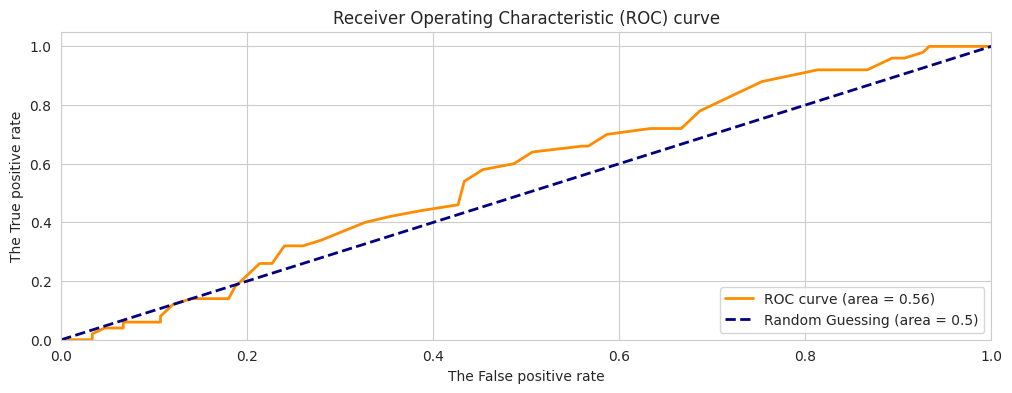

In [30]:
from sklearn.metrics import roc_curve, auc

# Calculate predict_proba
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

# cal fpr (false positive rate), tpr (true positive rate) & threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_curve = auc(fpr, tpr)

# Plot the curve
plt.figure(figsize=(12, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_curve:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guessing (area = 0.5)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("The False positive rate")
plt.ylabel("The True positive rate")
plt.title("Receiver Operating Characteristic (ROC) curve")
plt.legend(loc="lower right")
plt.show()

# XGBoost Classifier

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the Search Space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [1, 3, 5] # This specifically helps with your imbalanced churn
}

# Initialize Random Search
# We use scoring='f1' to balance Precision and Recall
random_search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss'),
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# # Initialize XGBoost
# xgb_classifier = XGBClassifier(
#     n_estimators=100,
#     learning_rate=0.05,
#     max_depth=4,
#     random_state=42,
#     eval_metric="logloss"
# )

# Fit
random_search.fit(X_train, y_train)

# get the best ver of the model
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# results
print("Best parameters:")
print(random_search.best_params_)
print("Accuracy Score")
print(f"{accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matirx")
print(confusion_matrix(y_test, y_pred))
print("Classification Report")
print(classification_report(y_test, y_pred))

# # fit
# xgb_classifier.fit(X_train, y_train)

# # predict
# y_pred_xgb = xgb_classifier.predict(X_test)

# # results
# print("Accuracy Score")
# print(f"{accuracy_score(y_test, y_pred_xgb):.4f}")
# print("Confusion Matirx")
# print(confusion_matrix(y_test, y_pred_xgb))
# print("Classification Report")
# print(classification_report(y_test, y_pred_xgb))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters:
{'scale_pos_weight': 3, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Accuracy Score
0.6350
Confusion Matirx
[[115  35]
 [ 38  12]]
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       150
           1       0.26      0.24      0.25        50

    accuracy                           0.64       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.63      0.64      0.63       200



# ROC-curve

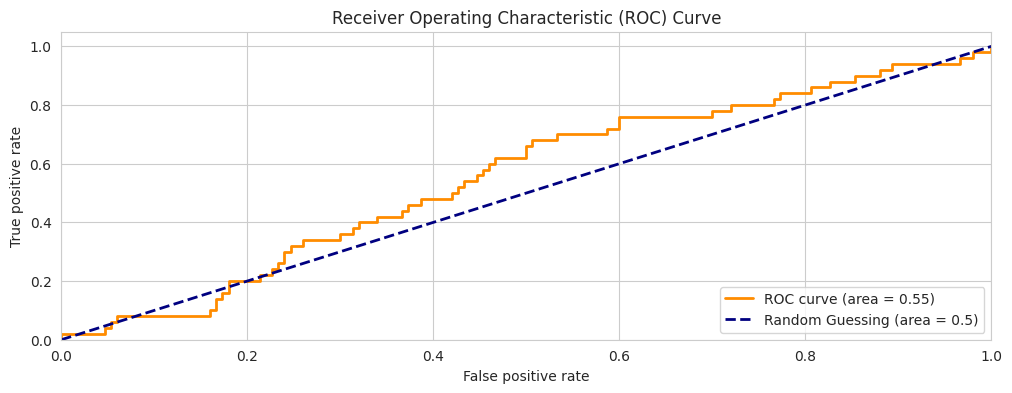

In [35]:
from sklearn.metrics import roc_curve, auc

# cal predict proba
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Cal fpr, tpr and threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# plot
plt.figure(figsize=(12, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guessing (area = 0.5)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Feature Importance

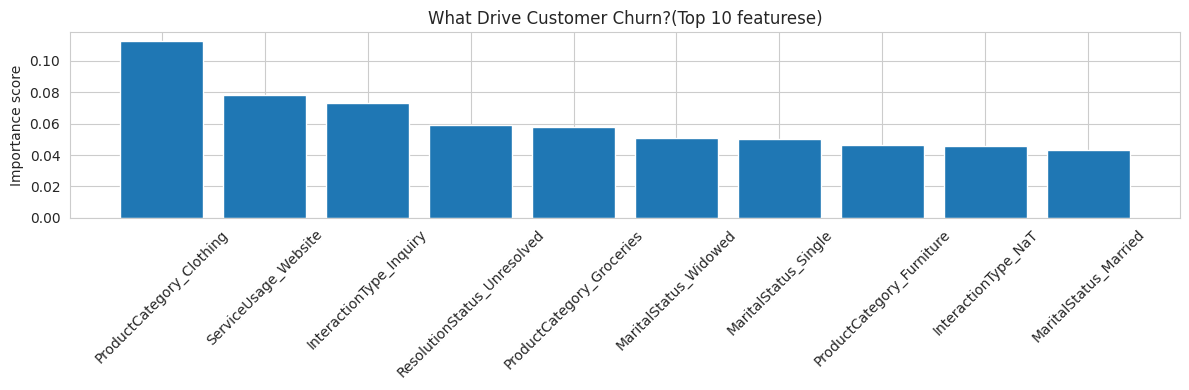

In [38]:
import numpy as np
# get feature imp from the xgboost model
feature_importance = best_xgb.feature_importances_
feature_names = X.columns

# sort them in descending order
indices = np.argsort(feature_importance)[::-1]

# plot
plt.figure(figsize=(12, 4))
plt.title("What Drive Customer Churn?(Top 10 featurese)")
plt.bar(range(10), feature_importance[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.ylabel("Importance score")
plt.tight_layout()
plt.show()

Note:- Based on the above charts we see that those feautres holds weightage to what drive customer churn.

1. ProductCategory_Clothing: This is our 1 predictor. This suggests that people who buy clothes have a very specific churn pattern. Perhaps they are "one-time buyers" who come for a specific item and never return, or perhaps there is a high return rate in this category that causes frustration.

2. ServiceUsage_Website: The way people use website is the second most important factor. This usually points to a "User Experience" issue. If a customer primarily uses the website (rather than an app or physical store) and then churns, the website might be difficult to navigate by the users.

3. InteractionType_Inquiry: Customers who reach out just to "inquire" (ask questions) are showing a high intent to either stay or leave. If their questions aren't answered well, they simply leave.

4. ResolutionStatus_Unresolved: This is 4th. It tells you that bad customer service is directly killing retention. If a customer has an issue and it stays "Unresolved," the model sees a massive spike in the probability that they will quit.

5. MaritalStatus: These features are more important than Age. This suggests that lifestyle and household structure play a bigger role in whether someone keeps your service than simply how old they are.

Important Note: Well i assume that the age, amountspent, rececny holds features imp that drives cust churn but still they arent deciding factors. A cust could be 25 or 65 if the inquiry is Unresolved they are likely to be churned regardless of the age.